# Time Series Forecasting using Regression
- This tutorial covers developing a Regression model, `Light Gradient Boosting Regresison` model, in this case, to predict forecasts for a multi-variate time series data.
- [uschange](https://rdrr.io/github/robjhyndman/fpp/man/uschange.html) dataset from the `fpp` package in R language has been taken for model development. This data covers percentage changes in quarterly personal consumption expenditure, personal disposable income, production, savings, and the unemployment rate for the US, 1960 to 2016,

In [1]:
# importing libraries necessary for data transformation, data pre-processing, model development etc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import warnings
from warnings import filterwarnings
filterwarnings('ignore')

### 1. Data import and exploratory analysis

In [2]:
# model development data

df = pd.read_csv('/content/uschange.csv')
print(df.head())

         Date  Consumption    Income  Production   Savings  Unemployment
0  1970-01-01     0.615986  0.972261   -2.452700  4.810312           0.9
1  1970-04-01     0.460376  1.169085   -0.551525  7.287992           0.5
2  1970-07-01     0.876791  1.553271   -0.358708  7.289013           0.5
3  1970-10-01    -0.274245 -0.255272   -2.185455  0.985230           0.7
4  1971-01-01     1.897371  1.987154    1.909734  3.657771          -0.1


In [3]:
# converting index into Consumption dates : this will later help in plotting sales with right time

df_change = df.copy()
df_change.index = pd.to_datetime(df_change.Date)
df_change = df_change.drop(['Date'], axis=1)
print(df_change.head(2))
print(df_change.tail(2))
print('Dataset shape : {}'.format(df_change.shape))

            Consumption    Income  Production   Savings  Unemployment
Date                                                                 
1970-01-01     0.615986  0.972261   -2.452700  4.810312           0.9
1970-04-01     0.460376  1.169085   -0.551525  7.287992           0.5
            Consumption    Income  Production   Savings  Unemployment
Date                                                                 
2016-04-01     1.047707  0.723721   -0.203319 -2.721501          -0.1
2016-07-01     0.729598  0.644701    0.474918 -0.572858           0.0
Dataset shape : (187, 5)


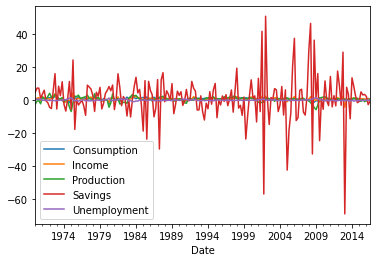

In [4]:
# On plotting the data we can see that this data-set captures different economics metrics data for
# around 46 years(187 quarters). Next step is to plot and see these mutliple Time-Series.

df_change.plot()
plt.show()

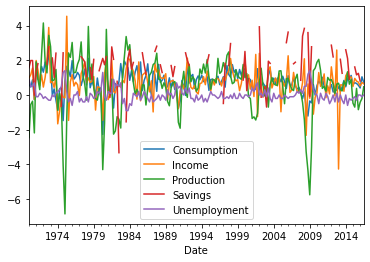

In [5]:
# Total 5 different Time-Series are present in this dataset.
# Savings data has the most volatility, lets take a log-transform for this metric

df_change['Savings'] = np.log(df_change['Savings']+0.001)
df_change.plot()
plt.show()

### 2. Feature Engineering

In [6]:
# Extracting Year and Quarters as new 'X' features

df_change['Year'] = df_change.index.year
df_change['Quarter'] = df_change.index.quarter
df_change.head()

,Consumption,Income,Production,Savings,Unemployment,Year,Quarter
Date,,,,,,,
1970-01-01,0.615986,0.972261,-2.452700,1.570970,0.9,1970,1
1970-04-01,0.460376,1.169085,-0.551525,1.986365,0.5,1970,2
1970-07-01,0.876791,1.553271,-0.358708,1.986505,0.5,1970,3
1970-10-01,-0.274245,-0.255272,-2.185455,-0.013866,0.7,1970,4
1971-01-01,1.897371,1.987154,1.909734,1.297127,-0.1,1971,1


Q : How to handle Year and Quarter? 
    Year as a int column<br>
    Current Quarter as dummy variable<br>
    Year-Quarter 1 lag and Quarter int<br> 
    Year-Quarter 1 lag and Quarter dummy<br>    

In [7]:
# Creating lags for all the 5 time-series.
# Taking 4 lag values for all time series. Later we will drop the current value columns.
# The reason to do so is to make *Ex-ante* forecasts 
# Values for Income, Prodcution, Savings, Unemployment upto a given Quarter should be used 
# to predict Consumption for the next Quarter. 

df_change_lags = df_change.copy()
lags = range(1, 5)
columns = ['Consumption', 'Income', 'Production', 'Savings', 'Unemployment']

for column in columns:
    df_change_lags = (df_change_lags
                      .assign(**{'{}_Lag_{}'
                      .format(column, lag): df_change_lags[column].shift(lag) for lag in lags}))

columns.remove('Consumption')
df_change_lags.drop(columns=columns, axis=1, inplace=True)    

print('Lagged Dataset shape : {}'.format(df_change_lags.shape))
df_change_lags.head()

Lagged Dataset shape : (187, 23)


,Consumption,Year,Quarter,Consumption_Lag_1,Consumption_Lag_2,Consumption_Lag_3,Consumption_Lag_4,Income_Lag_1,Income_Lag_2,Income_Lag_3,...,Production_Lag_3,Production_Lag_4,Savings_Lag_1,Savings_Lag_2,Savings_Lag_3,Savings_Lag_4,Unemployment_Lag_1,Unemployment_Lag_2,Unemployment_Lag_3,Unemployment_Lag_4
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-01,0.615986,1970,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-04-01,0.460376,1970,2,0.615986,NaN,NaN,NaN,0.972261,NaN,NaN,...,NaN,NaN,1.570970,NaN,NaN,NaN,0.9,NaN,NaN,NaN
1970-07-01,0.876791,1970,3,0.460376,0.615986,NaN,NaN,1.169085,0.972261,NaN,...,NaN,NaN,1.986365,1.570970,NaN,NaN,0.5,0.9,NaN,NaN
1970-10-01,-0.274245,1970,4,0.876791,0.460376,0.615986,NaN,1.553271,1.169085,0.972261,...,-2.452700,NaN,1.986505,1.986365,1.570970,NaN,0.5,0.5,0.9,NaN
1971-01-01,1.897371,1971,1,-0.274245,0.876791,0.460376,0.615986,-0.255272,1.553271,1.169085,...,-0.551525,-2.4527,-0.013866,1.986505,1.986365,1.57097,0.7,0.5,0.5,0.9


<Figure size 1080x504 with 0 Axes>

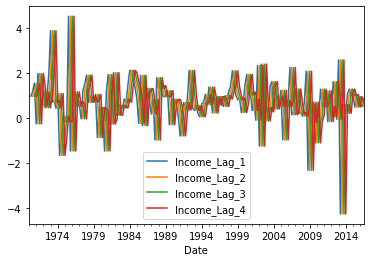

In [8]:
# Plotting all the lagged income values

plt.figure(figsize=(15,7))
fig_df = df_change_lags[['Income_Lag_1','Income_Lag_2','Income_Lag_3','Income_Lag_4']] 
fig_df.plot()
plt.show()

### 3. Train/Test data definition

In [9]:
# convert Quarter column into a dummy/one-hot-encoded data
df_change_lags = pd.get_dummies(df_change_lags, columns=['Quarter'], drop_first=True)

# Split model development data into test and train dataset, such that :

# Data for 164 Quarters : (4th Quarter to 168th Quarter) for training data
train_df = df_change_lags.iloc[4:168]
display(train_df.shape)
display(train_df.head(1))
display(train_df.tail(1))

# Data for 19 Quarters : (169th Quarter to 187th Quarter) for testin data
test_df = df_change_lags.iloc[-19:]
display(test_df.shape)
display(test_df.head(1))
display(test_df.tail(1))

(164, 25)

,Consumption,Year,Consumption_Lag_1,Consumption_Lag_2,Consumption_Lag_3,Consumption_Lag_4,Income_Lag_1,Income_Lag_2,Income_Lag_3,Income_Lag_4,...,Savings_Lag_2,Savings_Lag_3,Savings_Lag_4,Unemployment_Lag_1,Unemployment_Lag_2,Unemployment_Lag_3,Unemployment_Lag_4,Quarter_2,Quarter_3,Quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
1971-01-01,1.897371,1971,-0.274245,0.876791,0.460376,0.615986,-0.255272,1.553271,1.169085,0.972261,...,1.986505,1.986365,1.57097,0.7,0.5,0.5,0.9,0,0,0


,Consumption,Year,Consumption_Lag_1,Consumption_Lag_2,Consumption_Lag_3,Consumption_Lag_4,Income_Lag_1,Income_Lag_2,Income_Lag_3,Income_Lag_4,...,Savings_Lag_2,Savings_Lag_3,Savings_Lag_4,Unemployment_Lag_1,Unemployment_Lag_2,Unemployment_Lag_3,Unemployment_Lag_4,Quarter_2,Quarter_3,Quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-01,0.335939,2011,0.433726,0.20142,0.500413,1.018339,0.528913,-0.156581,1.215715,0.694952,...,NaN,2.663025,NaN,-0.1,0.1,-0.3,-0.2,0,0,1


(19, 25)

,Consumption,Year,Consumption_Lag_1,Consumption_Lag_2,Consumption_Lag_3,Consumption_Lag_4,Income_Lag_1,Income_Lag_2,Income_Lag_3,Income_Lag_4,...,Savings_Lag_2,Savings_Lag_3,Savings_Lag_4,Unemployment_Lag_1,Unemployment_Lag_2,Unemployment_Lag_3,Unemployment_Lag_4,Quarter_2,Quarter_3,Quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.60109,2012,0.335939,0.433726,0.20142,0.500413,0.060747,0.528913,-0.156581,1.215715,...,1.001919,NaN,2.663025,-0.5,-0.1,0.1,-0.3,0,0,0


,Consumption,Year,Consumption_Lag_1,Consumption_Lag_2,Consumption_Lag_3,Consumption_Lag_4,Income_Lag_1,Income_Lag_2,Income_Lag_3,Income_Lag_4,...,Savings_Lag_2,Savings_Lag_3,Savings_Lag_4,Unemployment_Lag_1,Unemployment_Lag_2,Unemployment_Lag_3,Unemployment_Lag_4,Quarter_2,Quarter_3,Quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-01,0.729598,2016,1.047707,0.404682,0.56168,0.66497,0.723721,0.519025,0.740063,0.801663,...,0.805374,1.24812,1.157488,-0.1,0.0,0.0,-0.3,0,1,0


In [10]:
# Defininig Consumption as Target/Y variable

Y_train = train_df.pop('Consumption')
X_train = train_df
display(X_train.head(2))
display(X_train.tail(2))

,Year,Consumption_Lag_1,Consumption_Lag_2,Consumption_Lag_3,Consumption_Lag_4,Income_Lag_1,Income_Lag_2,Income_Lag_3,Income_Lag_4,Production_Lag_1,...,Savings_Lag_2,Savings_Lag_3,Savings_Lag_4,Unemployment_Lag_1,Unemployment_Lag_2,Unemployment_Lag_3,Unemployment_Lag_4,Quarter_2,Quarter_3,Quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
1971-01-01,1971,-0.274245,0.876791,0.460376,0.615986,-0.255272,1.553271,1.169085,0.972261,-2.185455,...,1.986505,1.986365,1.570970,0.7,0.5,0.5,0.9,0,0,0
1971-04-01,1971,1.897371,-0.274245,0.876791,0.460376,1.987154,-0.255272,1.553271,1.169085,1.909734,...,-0.013866,1.986505,1.986365,-0.1,0.7,0.5,0.5,1,0,0


,Year,Consumption_Lag_1,Consumption_Lag_2,Consumption_Lag_3,Consumption_Lag_4,Income_Lag_1,Income_Lag_2,Income_Lag_3,Income_Lag_4,Production_Lag_1,...,Savings_Lag_2,Savings_Lag_3,Savings_Lag_4,Unemployment_Lag_1,Unemployment_Lag_2,Unemployment_Lag_3,Unemployment_Lag_4,Quarter_2,Quarter_3,Quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
2011-07-01,2011,0.201420,0.500413,1.018339,0.645019,-0.156581,1.215715,0.694952,0.496781,0.218787,...,2.663025,NaN,NaN,0.1,-0.3,-0.2,0.1,0,1,0
2011-10-01,2011,0.433726,0.201420,0.500413,1.018339,0.528913,-0.156581,1.215715,0.694952,1.011139,...,NaN,2.663025,NaN,-0.1,0.1,-0.3,-0.2,0,0,1


In [11]:
Y_test = test_df.pop('Consumption')
X_test = test_df
display(Y_test.head(2))
display(X_test.tail(2))

Date
2012-01-01    0.60109
2012-04-01    0.16943
Name: Consumption, dtype: float64

,Year,Consumption_Lag_1,Consumption_Lag_2,Consumption_Lag_3,Consumption_Lag_4,Income_Lag_1,Income_Lag_2,Income_Lag_3,Income_Lag_4,Production_Lag_1,...,Savings_Lag_2,Savings_Lag_3,Savings_Lag_4,Unemployment_Lag_1,Unemployment_Lag_2,Unemployment_Lag_3,Unemployment_Lag_4,Quarter_2,Quarter_3,Quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-01,2016,0.404682,0.561680,0.66497,0.708144,0.519025,0.740063,0.801663,0.954959,-0.417930,...,1.248120,1.157488,1.614409,0.0,0.0,-0.3,-0.1,1,0,0
2016-07-01,2016,1.047707,0.404682,0.56168,0.664970,0.723721,0.519025,0.740063,0.801663,-0.203319,...,0.805374,1.248120,1.157488,-0.1,0.0,0.0,-0.3,0,1,0


### 4. Model Development



In [12]:
# defining Light Gradient Boosting model with relevant hyper-parameters
lgb_model = lgb.LGBMRegressor(learning_rate=0.3, max_depth=3, n_estimators=15, random_state=21)

# fitting model on training data
lgb_model.fit(X_train, Y_train)

LGBMRegressor(learning_rate=0.3, max_depth=3, n_estimators=15, random_state=21)

Train MAE : 0.29 
Test MAE : 0.3


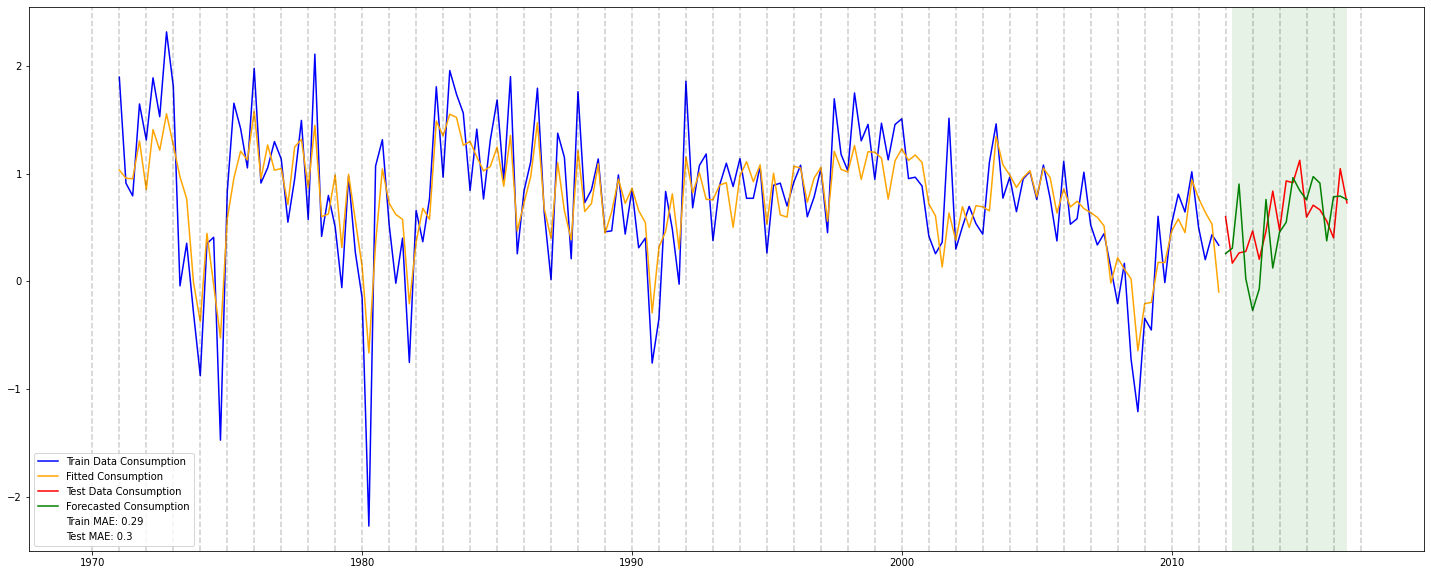

In [13]:
# fit model on train data to calculate Train data error metric (Mean Absolute Error)
Y_fit = lgb_model.predict(X_train)
Y_fit = pd.Series(Y_fit, index=Y_train.index)
train_error = round((mean_absolute_error(Y_train, Y_fit)),2)

# get forecasts and calculate Test data error metric (Mean Absolute Error)
Y_pred = lgb_model.predict(X_test)
Y_pred = pd.Series(Y_pred, index=Y_test.index)
test_error = round((mean_absolute_error(Y_test, Y_pred)),2)

# compare Train and Test error metrics
print('Train MAE : {}'.format(train_error),'\nTest MAE : {}'.format(test_error))

# plot model forecasts
plt.figure(figsize=(25,10))
plt.plot(Y_train, label='Train Data Consumption', color = 'blue')
plt.plot(Y_fit, label='Fitted Consumption', color = 'orange')
plt.plot(Y_test, label='Test Data Consumption', color = 'red')
plt.plot(Y_pred, label = 'Forecasted Consumption', color = 'green')
plt.plot(Y_train.index[0], 0, label = 'Train MAE: {}'.format(train_error), color = 'white')
plt.plot(Y_train.index[0], 0, label = 'Test MAE: {}'.format(test_error), color = 'white')
for year in range(df_change.index[0].year, df_change.index[186].year+2):
    plt.axvline(pd.to_datetime(str(year)), color='k', linestyle='--', alpha=0.2, )
plt.axvspan(df_change.index[169], df_change.index[186], facecolor='green', alpha=0.1)
plt.legend()
plt.show()   